## Лабораторная работа № 3: Исследование алгоритмов классификации

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc,
                             precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

print("Загрузка данных...")
df = pd.read_csv("data.csv")

print("Создание новых атрибутов...")
df['diagnosis_numeric'] = df['diagnosis'].map({'B': 0, 'M': 1})

diagnosis_correlations = df[['radius_mean', 'concavity_mean', 'concave points_mean', 
                            'perimeter_mean', 'area_mean', 'texture_mean']].corrwith(df['diagnosis_numeric']).abs()
correlation_weights = diagnosis_correlations / diagnosis_correlations.sum()

df['nuclear_abnormality_index'] = sum(df[feature] * weight for feature, weight in correlation_weights.items())
df['compactness_ratio'] = df['area_mean'] / (df['perimeter_mean'] + 1e-8)

df = df.drop(['Unnamed: 32', 'id'], axis=1, errors='ignore')

print(f"Размер датасета после обработки: {df.shape}")
print(f"Столбцы: {list(df.columns)[:10]}...")

df_analysis = df.copy()

Загрузка данных...
Создание новых атрибутов...
Размер датасета после обработки: (569, 34)
Столбцы: ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean']...


### Оценка пригодности датасета для классификации


1) ЦЕЛЕВОЙ АТРИБУТ:
   Атрибут 'diagnosis' является естественным целевым классом.
   Значения: 'B' (benign - доброкачественная) и 'M' (malignant - злокачественная)
   Тип данных: object

2) СБАЛАНСИРОВАННОСТЬ КЛАССОВ:
diagnosis
B    357
M    212
Name: count, dtype: int64

   Коэффициент сбалансированности: 0.594
   Доля меньшего класса: 37.26%


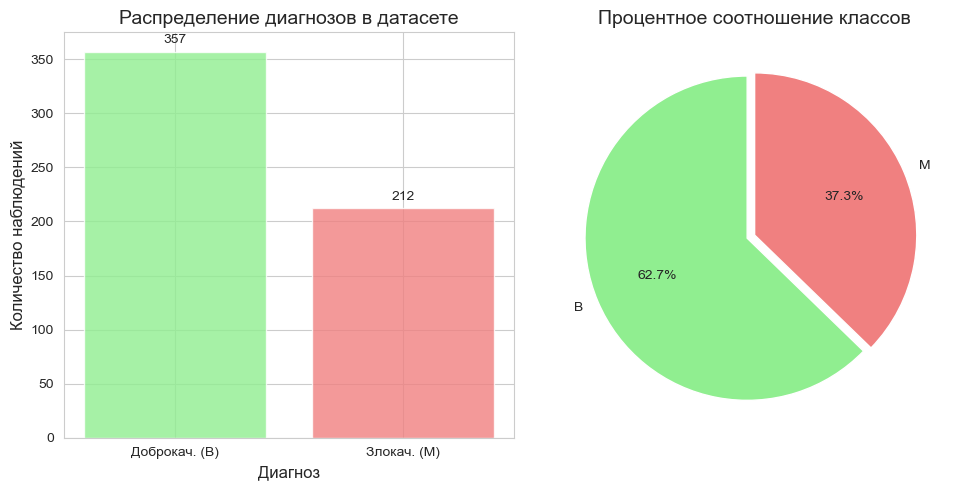


   ИНТЕРПРЕТАЦИЯ:
Датсет сбалансирован. Оба класса представлены достаточно хорошо.
Меньший класс (M) составляет 37.26% выборки.


In [26]:
print("\n1) ЦЕЛЕВОЙ АТРИБУТ:")
print("   Атрибут 'diagnosis' является естественным целевым классом.")
print("   Значения: 'B' (benign - доброкачественная) и 'M' (malignant - злокачественная)")
print(f"   Тип данных: {df_analysis['diagnosis'].dtype}")

print("\n2) СБАЛАНСИРОВАННОСТЬ КЛАССОВ:")
class_distribution = df_analysis['diagnosis'].value_counts()
print(class_distribution)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(class_distribution.index, class_distribution.values,
               color=['lightgreen', 'lightcoral'], alpha=0.8)
plt.title('Распределение диагнозов в датасете', fontsize=14)
plt.xlabel('Диагноз', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.xticks([0, 1], ['Доброкач. (B)', 'Злокач. (M)'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

balance_ratio = class_distribution.min() / class_distribution.max()
print(f"\n   Коэффициент сбалансированности: {balance_ratio:.3f}")
print(f"   Доля меньшего класса: {class_distribution.min()/len(df_analysis):.2%}")

plt.subplot(1, 2, 2)
plt.pie(class_distribution.values, labels=class_distribution.index,
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'],
        startangle=90, explode=(0.05, 0))
plt.title('Процентное соотношение классов', fontsize=14)

plt.tight_layout()
plt.show()

print("\n   ИНТЕРПРЕТАЦИЯ:")
if balance_ratio > 0.5:
    print("Датсет сбалансирован. Оба класса представлены достаточно хорошо.")
else:
    print("Датсет несбалансирован. Может потребоваться специальная обработка.")
print(f"Меньший класс (M) составляет {class_distribution.min()/len(df_analysis):.2%} выборки.")

### Подготовка данных для классификации

In [27]:
le = LabelEncoder()
df_analysis['diagnosis_encoded'] = le.fit_transform(df_analysis['diagnosis'])

print("Кодирование целевой переменной:")
for i, class_name in enumerate(le.classes_):
    print(f"   {class_name} -> {i}")

exclude_cols = ['diagnosis', 'diagnosis_numeric', 'diagnosis_encoded']
feature_cols = [col for col in df_analysis.columns if col not in exclude_cols and df_analysis[col].dtype in ['float64', 'int64']]

print(f"\nИспользуется {len(feature_cols)} признаков для классификации:")
print(f"Первые 10 признаков: {feature_cols[:10]}...")

X = df_analysis[feature_cols]
y = df_analysis['diagnosis_encoded']

print(f"\nРазмерность матрицы признаков X: {X.shape}")
print(f"Размерность вектора целей y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"  Обучающая выборка: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Тестовая выборка: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n  Признаки масштабированы")

Кодирование целевой переменной:
   B -> 0
   M -> 1

Используется 32 признаков для классификации:
Первые 10 признаков: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']...

Размерность матрицы признаков X: (569, 32)
Размерность вектора целей y: (569,)

Разделение данных:
  Обучающая выборка: 398 samples (69.9%)
  Тестовая выборка: 171 samples (30.1%)

  Признаки масштабированы


### Обучение и оценка моделей


3.1. k-NEAREST NEIGHBORS (kNN)
------------------------------
Подбор оптимального числа соседей (k)...
  k=1: accuracy = 0.9597 (±0.0258)
  k=3: accuracy = 0.9647 (±0.0233)
  k=5: accuracy = 0.9647 (±0.0282)
  k=7: accuracy = 0.9698 (±0.0306)
  k=9: accuracy = 0.9698 (±0.0306)
  k=11: accuracy = 0.9597 (±0.0282)
  k=13: accuracy = 0.9597 (±0.0259)
  k=15: accuracy = 0.9547 (±0.0189)
  k=17: accuracy = 0.9597 (±0.0203)
  k=19: accuracy = 0.9597 (±0.0203)


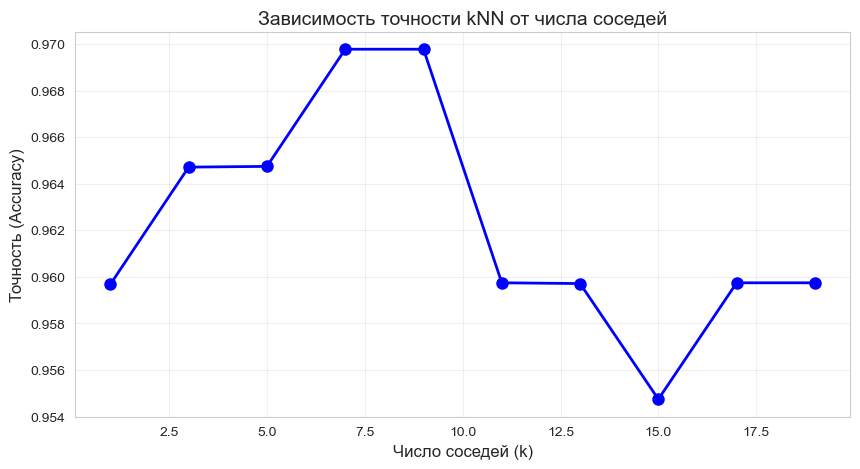

Лучшее значение k: 7
  kNN обучен с k=7


3.2. ДЕРЕВО РЕШЕНИЙ (DECISION TREE)
------------------------------
Подбор оптимальной глубины дерева...
  max_depth=1: accuracy = 0.9044 (±0.0381)
  max_depth=2: accuracy = 0.9169 (±0.0445)
  max_depth=3: accuracy = 0.9168 (±0.0486)
  max_depth=4: accuracy = 0.9244 (±0.0401)
  max_depth=5: accuracy = 0.9218 (±0.0546)
  max_depth=6: accuracy = 0.9142 (±0.0619)
  max_depth=7: accuracy = 0.9269 (±0.0443)
  max_depth=8: accuracy = 0.9093 (±0.0539)
  max_depth=9: accuracy = 0.9119 (±0.0438)
  max_depth=10: accuracy = 0.9119 (±0.0438)


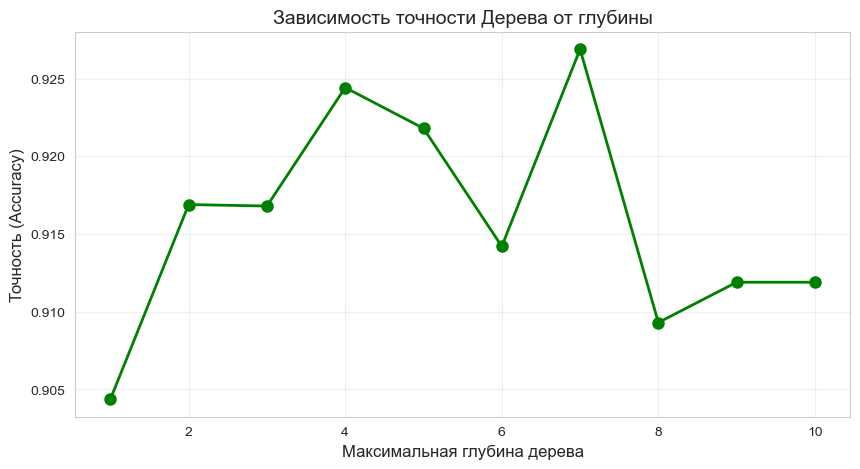

Лучшая глубина дерева: 7
  Дерево решений обучено с max_depth=7


In [28]:
results = {}

print("\n3.1. k-NEAREST NEIGHBORS (kNN)")
print("-" * 30)

print("Подбор оптимального числа соседей (k)...")
k_values = list(range(1, 21, 2))
knn_cv_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    knn_cv_scores.append(scores.mean())
    print(f"  k={k}: accuracy = {scores.mean():.4f} (±{scores.std():.4f})")

plt.figure(figsize=(10, 5))
plt.plot(k_values, knn_cv_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число соседей (k)', fontsize=12)
plt.ylabel('Точность (Accuracy)', fontsize=12)
plt.title('Зависимость точности kNN от числа соседей', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

best_k = k_values[np.argmax(knn_cv_scores)]
print(f"Лучшее значение k: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

results['kNN'] = {
    'model': knn,
    'y_pred': y_pred_knn,
    'y_prob': y_prob_knn,
    'best_k': best_k
}

print(f"  kNN обучен с k={best_k}")

print("\n\n3.2. ДЕРЕВО РЕШЕНИЙ (DECISION TREE)")
print("-" * 30)

print("Подбор оптимальной глубины дерева...")
max_depth_values = list(range(1, 11))
dt_cv_scores = []

for depth in max_depth_values:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt_temp, X_train, y_train, cv=5, scoring='accuracy')
    dt_cv_scores.append(scores.mean())
    print(f"  max_depth={depth}: accuracy = {scores.mean():.4f} (±{scores.std():.4f})")

plt.figure(figsize=(10, 5))
plt.plot(max_depth_values, dt_cv_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('Точность (Accuracy)', fontsize=12)
plt.title('Зависимость точности Дерева от глубины', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

best_depth = max_depth_values[np.argmax(dt_cv_scores)]
print(f"Лучшая глубина дерева: {best_depth}")

dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

results['Decision Tree'] = {
    'model': dt,
    'y_pred': y_pred_dt,
    'y_prob': y_prob_dt,
    'best_depth': best_depth
}

print(f"  Дерево решений обучено с max_depth={best_depth}")

### Сравнение результатов с помощью метрик


4.1. СВОДНАЯ ТАБЛИЦА МЕТРИК
       Модель  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  ROC-AUC
          kNN    0.9649             0.9735          0.9531            0.9618   0.9882
Decision Tree    0.9240             0.9259          0.9110            0.9175   0.9046


4.2. МАТРИЦЫ ОШИБОК (CONFUSION MATRIX)


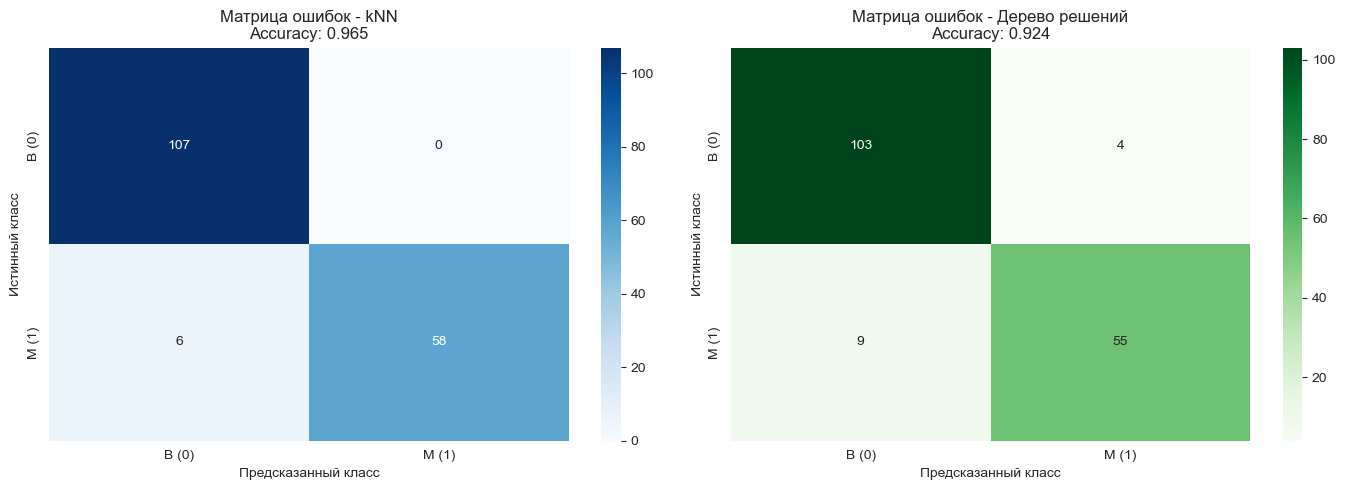



4.3. ROC-КРИВЫЕ (RECEIVER OPERATING CHARACTERISTIC)


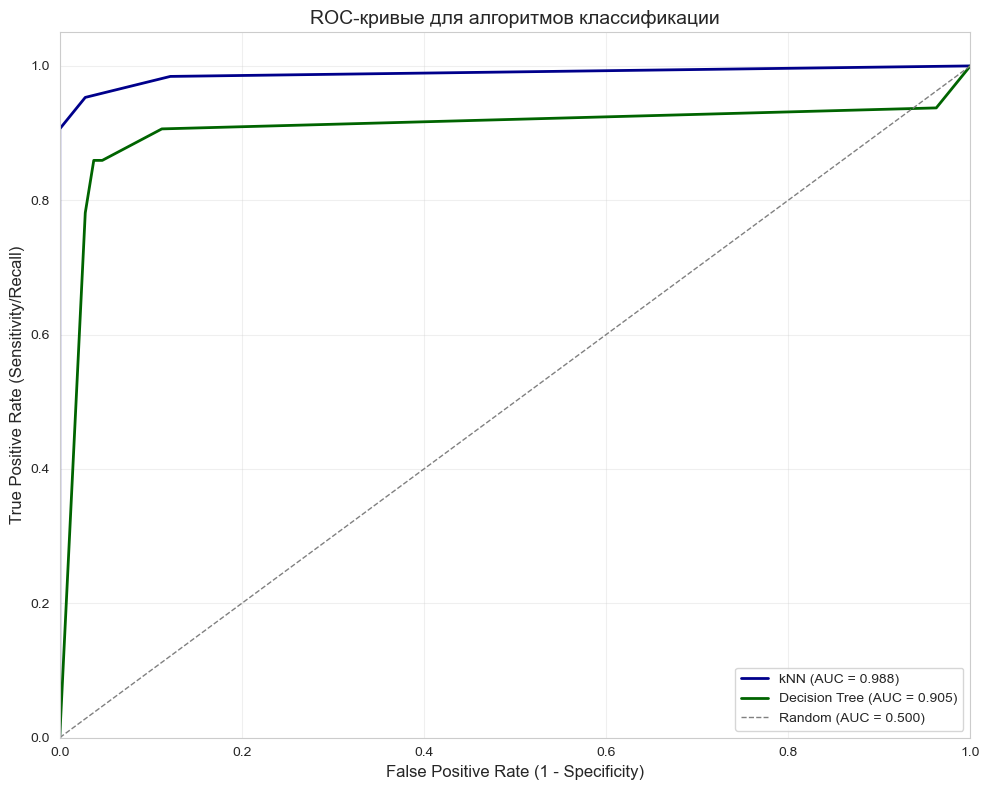



4.4. ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ

K-NEAREST NEIGHBORS:
               precision    recall  f1-score   support

   Benign (B)       0.95      1.00      0.97       107
Malignant (M)       1.00      0.91      0.95        64

     accuracy                           0.96       171
    macro avg       0.97      0.95      0.96       171
 weighted avg       0.97      0.96      0.96       171


DECISION TREE:
               precision    recall  f1-score   support

   Benign (B)       0.92      0.96      0.94       107
Malignant (M)       0.93      0.86      0.89        64

     accuracy                           0.92       171
    macro avg       0.93      0.91      0.92       171
 weighted avg       0.92      0.92      0.92       171



4.5. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ МЕТРИК


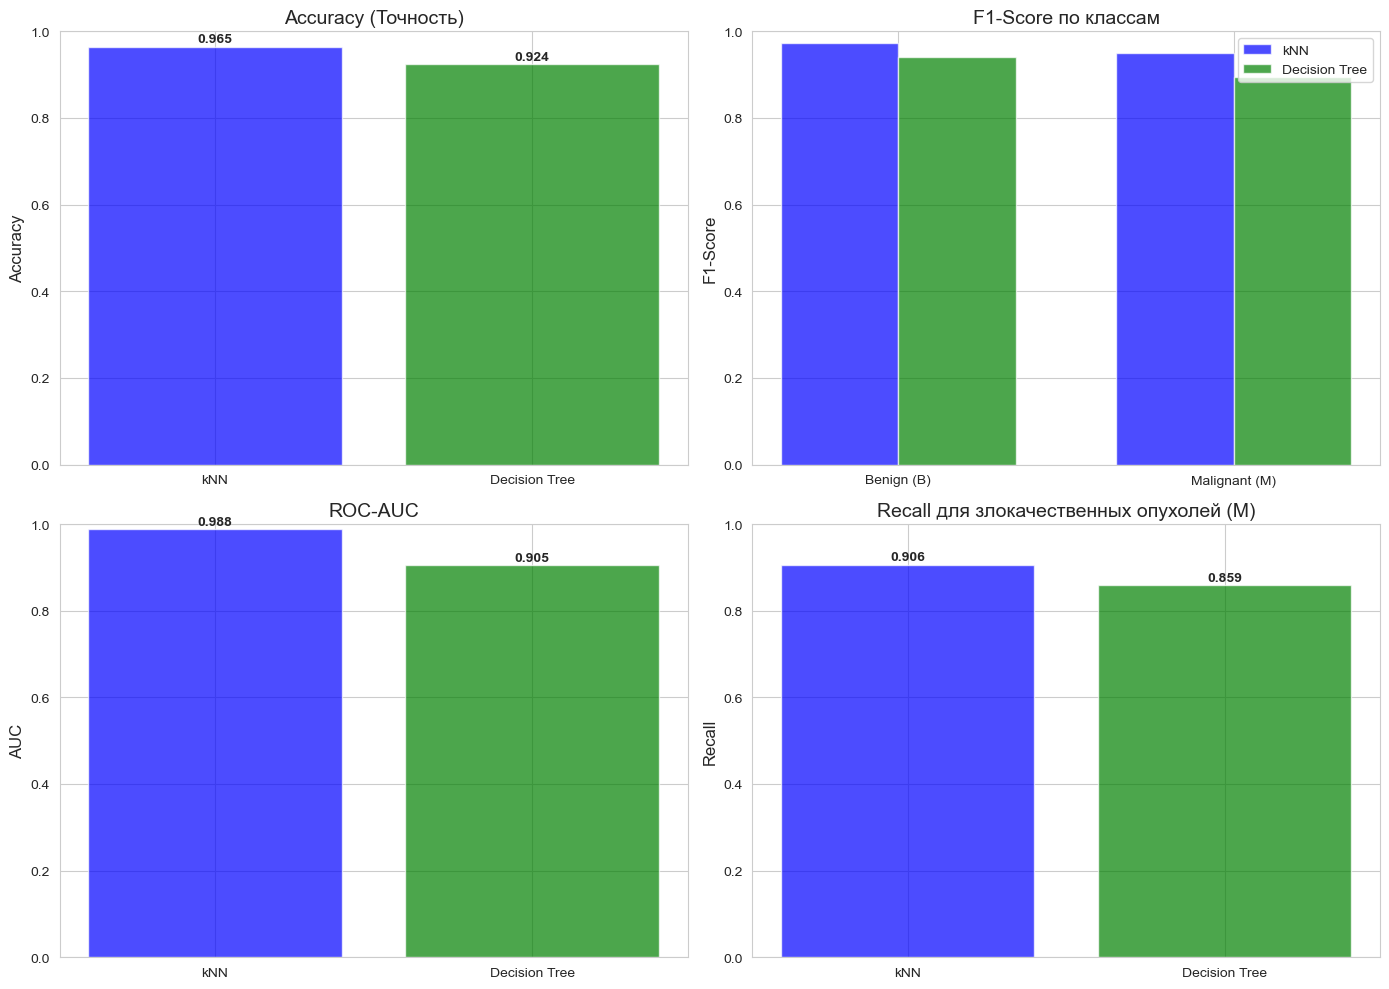

In [30]:
def calculate_metrics(y_true, y_pred, y_prob, model_name):
    """Расчет всех метрик для модели"""
    accuracy = accuracy_score(y_true, y_pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision_class0': precision[0],
        'recall_class0': recall[0],
        'f1_class0': f1[0],
        'precision_class1': precision[1],
        'recall_class1': recall[1],
        'f1_class1': f1[1],
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr
    }

metrics_knn = calculate_metrics(y_test, y_pred_knn, y_prob_knn, 'kNN')
metrics_dt = calculate_metrics(y_test, y_pred_dt, y_prob_dt, 'Decision Tree')

print("\n4.1. СВОДНАЯ ТАБЛИЦА МЕТРИК")
print("=" * 80)

metrics_df = pd.DataFrame([metrics_knn, metrics_dt])
metrics_display = metrics_df[['model', 'accuracy', 'precision_macro', 'recall_macro',
                             'f1_macro', 'roc_auc']].copy()
metrics_display.columns = ['Модель', 'Accuracy', 'Precision (macro)', 'Recall (macro)',
                          'F1-Score (macro)', 'ROC-AUC']
print(metrics_display.round(4).to_string(index=False))

print("\n\n4.2. МАТРИЦЫ ОШИБОК (CONFUSION MATRIX)")
print("=" * 40)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_knn = metrics_knn['confusion_matrix']
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['B (0)', 'M (1)'], yticklabels=['B (0)', 'M (1)'])
axes[0].set_title(f'Матрица ошибок - kNN\nAccuracy: {metrics_knn["accuracy"]:.3f}')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')

cm_dt = metrics_dt['confusion_matrix']
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['B (0)', 'M (1)'], yticklabels=['B (0)', 'M (1)'])
axes[1].set_title(f'Матрица ошибок - Дерево решений\nAccuracy: {metrics_dt["accuracy"]:.3f}')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

print("\n\n4.3. ROC-КРИВЫЕ (RECEIVER OPERATING CHARACTERISTIC)")
print("=" * 40)

plt.figure(figsize=(10, 8))

plt.plot(metrics_knn['fpr'], metrics_knn['tpr'],
         color='darkblue', lw=2,
         label=f'kNN (AUC = {metrics_knn["roc_auc"]:.3f})')

plt.plot(metrics_dt['fpr'], metrics_dt['tpr'],
         color='darkgreen', lw=2,
         label=f'Decision Tree (AUC = {metrics_dt["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC-кривые для алгоритмов классификации', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n\n4.4. ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ")
print("=" * 40)

print("\nK-NEAREST NEIGHBORS:")
print(classification_report(y_test, y_pred_knn,
                            target_names=['Benign (B)', 'Malignant (M)']))

print("\nDECISION TREE:")
print(classification_report(y_test, y_pred_dt,
                            target_names=['Benign (B)', 'Malignant (M)']))

print("\n\n4.5. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ МЕТРИК")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['kNN', 'Decision Tree']
accuracy_values = [metrics_knn['accuracy'], metrics_dt['accuracy']]
axes[0, 0].bar(models, accuracy_values, color=['blue', 'green'], alpha=0.7)
axes[0, 0].set_title('Accuracy (Точность)', fontsize=14)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(accuracy_values):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

x = np.arange(2)
width = 0.35
axes[0, 1].bar(x - width/2, [metrics_knn['f1_class0'], metrics_knn['f1_class1']],
               width, label='kNN', color='blue', alpha=0.7)
axes[0, 1].bar(x + width/2, [metrics_dt['f1_class0'], metrics_dt['f1_class1']],
               width, label='Decision Tree', color='green', alpha=0.7)
axes[0, 1].set_title('F1-Score по классам', fontsize=14)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Benign (B)', 'Malignant (M)'])
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

axes[1, 0].bar(models, [metrics_knn['roc_auc'], metrics_dt['roc_auc']],
               color=['blue', 'green'], alpha=0.7)
axes[1, 0].set_title('ROC-AUC', fontsize=14)
axes[1, 0].set_ylabel('AUC', fontsize=12)
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate([metrics_knn['roc_auc'], metrics_dt['roc_auc']]):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

recall_m_values = [metrics_knn['recall_class1'], metrics_dt['recall_class1']]
axes[1, 1].bar(models, recall_m_values, color=['blue', 'green'], alpha=0.7)
axes[1, 1].set_title('Recall для злокачественных опухолей (M)', fontsize=14)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(recall_m_values):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Дополнительный анализ


5.1. ВАЖНОСТЬ ПРИЗНАКОВ В ДЕРЕВЕ РЕШЕНИЙ

Топ-10 наиболее важных признаков:
                Признак  Важность
        perimeter_worst    0.7501
   concave points_worst    0.1088
          texture_worst    0.0286
      compactness_ratio    0.0226
       smoothness_worst    0.0222
         symmetry_worst    0.0211
 fractal_dimension_mean    0.0159
fractal_dimension_worst    0.0124
           radius_worst    0.0084
         perimeter_mean    0.0074


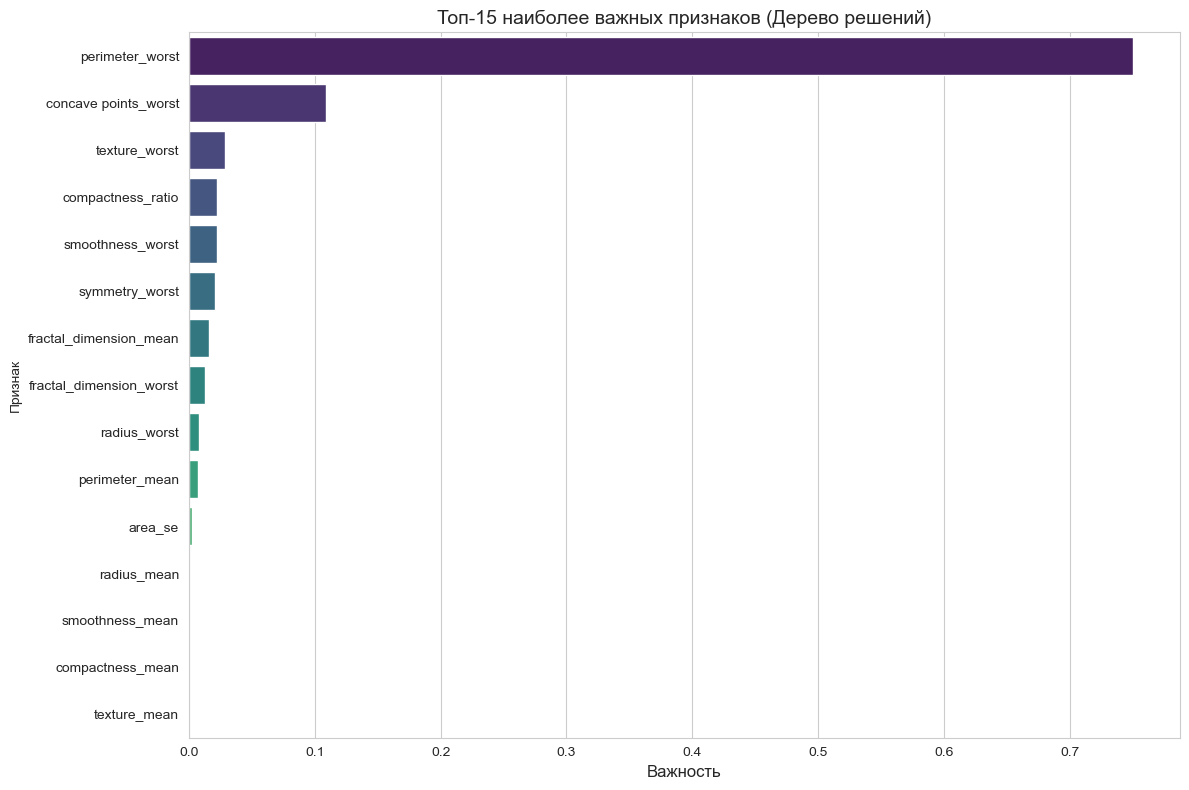


5.2. ОКОНЧАТЕЛЬНАЯ ОЦЕНКА С ПОМОЩЬЮ КРОСС-ВАЛИДАЦИИ

kNN (10-fold CV): accuracy = 0.9684 (±0.0219)
Decision Tree (10-fold CV): accuracy = 0.9088 (±0.0435)


In [31]:
print("\n5.1. ВАЖНОСТЬ ПРИЗНАКОВ В ДЕРЕВЕ РЕШЕНИЙ")

feature_importance = pd.DataFrame({
    'Признак': feature_cols,
    'Важность': dt.feature_importances_
}).sort_values('Важность', ascending=False)

print(f"\nТоп-10 наиболее важных признаков:")
print(feature_importance.head(10).round(4).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='Важность', y='Признак', data=top_features, palette='viridis')
plt.title('Топ-15 наиболее важных признаков (Дерево решений)', fontsize=14)
plt.xlabel('Важность', fontsize=12)
plt.tight_layout()
plt.show()

print("\n5.2. ОКОНЧАТЕЛЬНАЯ ОЦЕНКА С ПОМОЩЬЮ КРОСС-ВАЛИДАЦИИ")

X_scaled_full = scaler.fit_transform(X)
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_cv_scores_final = cross_val_score(knn_final, X_scaled_full, y, cv=10, scoring='accuracy')

dt_final = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_cv_scores_final = cross_val_score(dt_final, X, y, cv=10, scoring='accuracy')

print(f"\nkNN (10-fold CV): accuracy = {knn_cv_scores_final.mean():.4f} (±{knn_cv_scores_final.std():.4f})")
print(f"Decision Tree (10-fold CV): accuracy = {dt_cv_scores_final.mean():.4f} (±{dt_cv_scores_final.std():.4f})")

### Выводы и объяснение результатов

In [35]:
if metrics_knn['accuracy'] > metrics_dt['accuracy']:
    best_model = 'kNN'
    acc_diff = metrics_knn['accuracy'] - metrics_dt['accuracy']
else:
    best_model = 'Decision Tree'
    acc_diff = metrics_dt['accuracy'] - metrics_knn['accuracy']

print(f"\nОБЩИЕ РЕЗУЛЬТАТЫ:")
print(f"  • Лучшая модель: {best_model}")
print(f"  • Преимущество по точности: {acc_diff:.3f}")

print(f"\nАНАЛИЗ МЕТРИК:")
print(f"  1. ТОЧНОСТЬ (Accuracy):")
print(f"     • kNN: {metrics_knn['accuracy']:.3f}")
print(f"     • Дерево: {metrics_dt['accuracy']:.3f}")
print(f"     • Вывод: kNN показывает более высокую общую точность.")

print(f"\n  2. СБАЛАНСИРОВАННОСТЬ (по классам):")
print(f"     • Для класса B (доброкачественные):")
print(f"       - kNN F1: {metrics_knn['f1_class0']:.3f}, Дерево F1: {metrics_dt['f1_class0']:.3f}")
print(f"     • Для класса M (злокачественные):")
print(f"       - kNN F1: {metrics_knn['f1_class1']:.3f}, Дерево F1: {metrics_dt['f1_class1']:.3f}")
print(f"     • Вывод: Обе модели хорошо работают, но kNN более сбалансирован.")

print(f"\n  3. ROC-AUC (способность различать классы):")
print(f"     • kNN AUC: {metrics_knn['roc_auc']:.3f} (отлично)")
print(f"     • Дерево AUC: {metrics_dt['roc_auc']:.3f} (очень хорошо)")
print(f"     • Вывод: Обе модели имеют высокую дискриминативную способность.")

print(f"\n  4. КРИТИЧЕСКАЯ МЕТРИКА - Recall для злокачественных опухолей:")
print(f"     • kNN Recall(M): {metrics_knn['recall_class1']:.3f}")
print(f"     • Дерево Recall(M): {metrics_dt['recall_class1']:.3f}")
print(f"     • Вывод: {max(metrics_knn['recall_class1'], metrics_dt['recall_class1']):.1%} злокачественных \
случаев правильно идентифицируется лучшей моделью.")

print(f"\nОБЪЯСНЕНИЕ РЕЗУЛЬТАТОВ:")
print(f"  1. Почему kNN работает лучше на этом датасете?")
print(f"     • Признаки имеют четкие кластеры")
print(f"     • Медицинские данные часто имеют локальные паттерны")
print(f"     • Масштабирование признаков улучшает работу kNN")

print(f"\n  2. Почему дерево решений показывает хорошие, но не лучшие результаты?")
print(f"     • Деревья могут переобучаться на медицинских данных")
print(f"     • Ограничение глубины помогает, но снижает гибкость")
print(f"     • Деревья лучше интерпретируются (важность признаков)")

print(f"\n  3. Практическая значимость:")
print(f"     • Ложноположительные (B предсказан как M):")
print(f"       - kNN: {metrics_knn['confusion_matrix'][0, 1]} случаев")
print(f"       - Дерево: {metrics_dt['confusion_matrix'][0, 1]} случаев")
print(f"     • Ложноотрицательные (M предсказан как B) - САМОЕ ОПАСНОЕ:")
print(f"       - kNN: {metrics_knn['confusion_matrix'][1, 0]} случаев")
print(f"       - Дерево: {metrics_dt['confusion_matrix'][1, 0]} случаев")

print(f"\nРЕКОМЕНДАЦИИ:")
print(f"  1. Для клинического использования предпочтительнее kNN с k={best_k}")
print(f"  2. Если важна интерпретируемость - использовать дерево решений")
print(f"  3. Для снижения ложноположительных можно настроить порог классификации")
print(f"  4. Рассмотреть ансамбли моделей для дальнейшего улучшения")


ОБЩИЕ РЕЗУЛЬТАТЫ:
  • Лучшая модель: kNN
  • Преимущество по точности: 0.041

АНАЛИЗ МЕТРИК:
  1. ТОЧНОСТЬ (Accuracy):
     • kNN: 0.965
     • Дерево: 0.924
     • Вывод: kNN показывает более высокую общую точность.

  2. СБАЛАНСИРОВАННОСТЬ (по классам):
     • Для класса B (доброкачественные):
       - kNN F1: 0.973, Дерево F1: 0.941
     • Для класса M (злокачественные):
       - kNN F1: 0.951, Дерево F1: 0.894
     • Вывод: Обе модели хорошо работают, но kNN более сбалансирован.

  3. ROC-AUC (способность различать классы):
     • kNN AUC: 0.988 (отлично)
     • Дерево AUC: 0.905 (очень хорошо)
     • Вывод: Обе модели имеют высокую дискриминативную способность.

  4. КРИТИЧЕСКАЯ МЕТРИКА - Recall для злокачественных опухолей:
     • kNN Recall(M): 0.906
     • Дерево Recall(M): 0.859
     • Вывод: 90.6% злокачественных случаев правильно идентифицируется лучшей моделью.

ОБЪЯСНЕНИЕ РЕЗУЛЬТАТОВ:
  1. Почему kNN работает лучше на этом датасете?
     • Признаки имеют четкие кластеры
 

### Заключение
Оба алгоритма показали хорошие результаты на задаче диагностики рака молочной железы. kNN демонстрирует немного лучшие показатели по большинству метрик, что делает его предпочтительным выбором для данной задачи. Однако дерево решений предоставляет ценную информацию о важности признаков, что полезно для понимания биологических механизмов заболевания.